<a href="https://colab.research.google.com/github/nachomendoza97/Data-Industrial/blob/main/Proyecto6_OPT_y_Scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

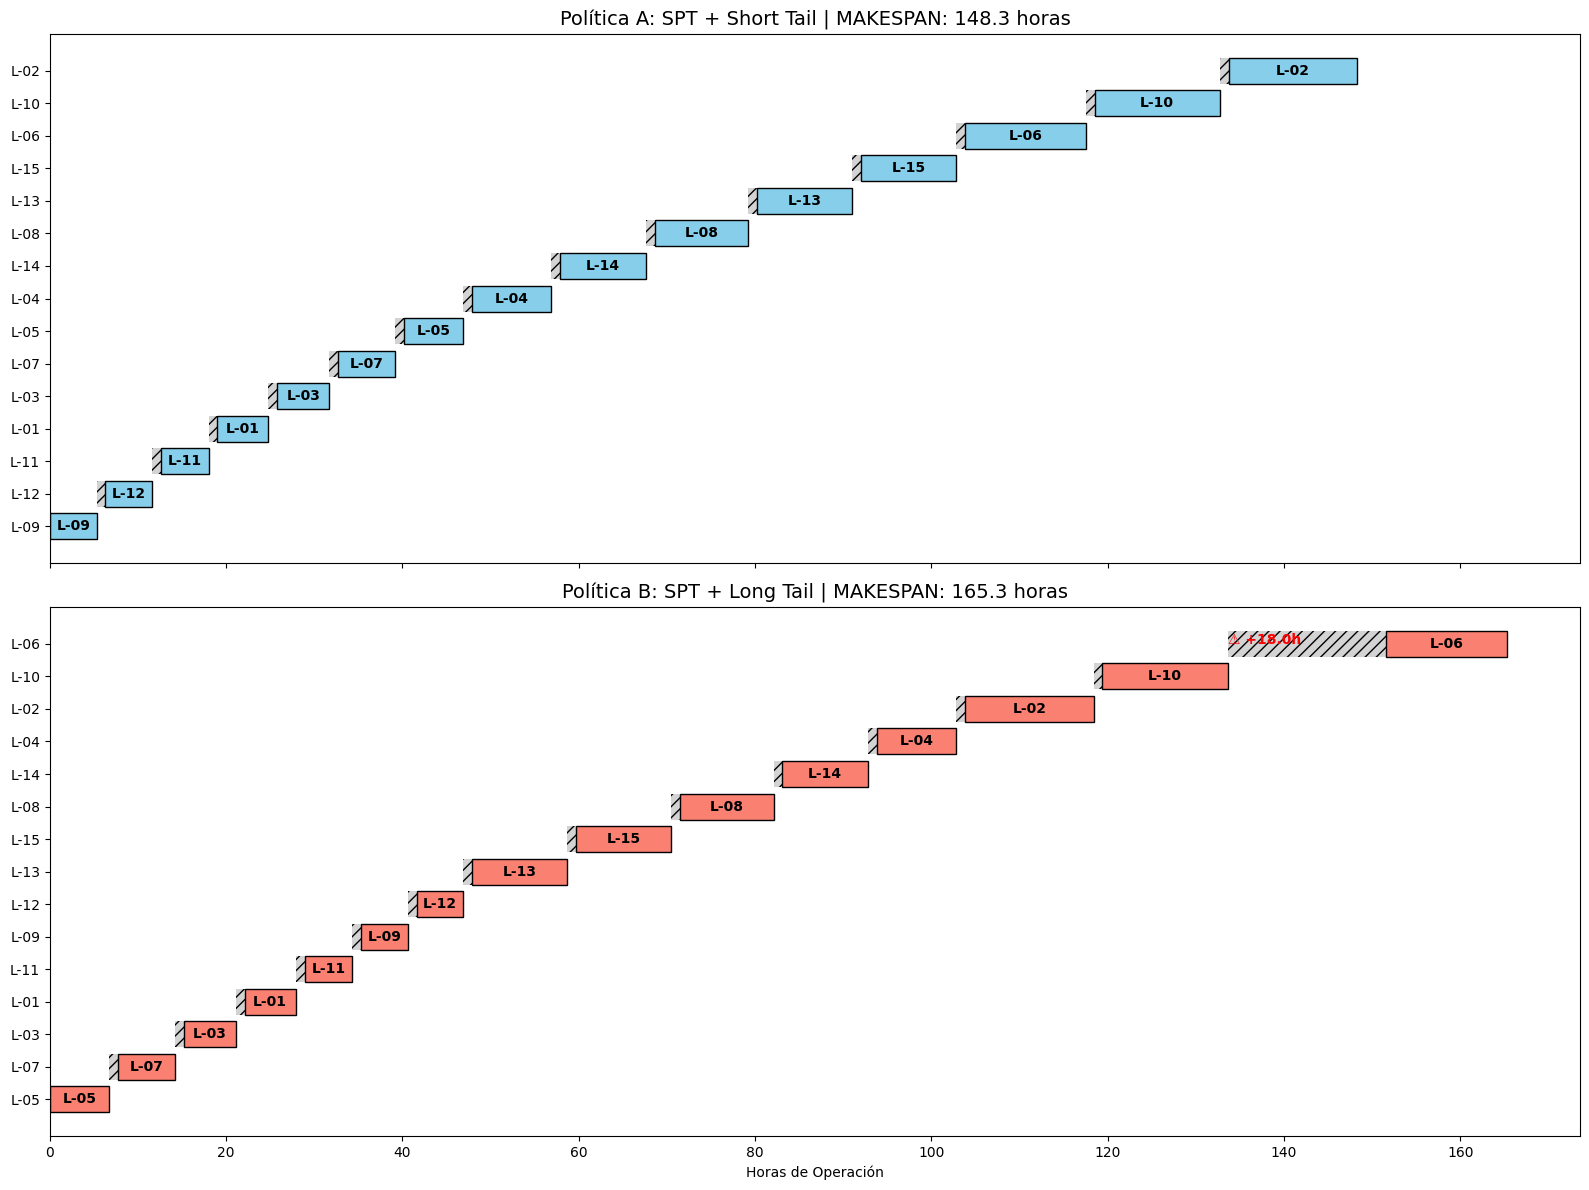

Diferencia de ahorro lograda: 17.0 horas.


In [6]:
##Simulacion de secuencia de procesamiento de lotes(batch) con reestricciones de procedencia
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. DATOS DE LOS LOTES (Forzamos empates en Tiempo de Proceso)
n_lotes = 15
tiempos_fijos = [4, 8, 12]
df_base = pd.DataFrame({
    'Lote_ID': [f'L-{i+1:02d}' for i in range(n_lotes)],
    'Tiempo_Proceso': np.random.choice(tiempos_fijos, n_lotes),
    'Setup_Estatico': np.random.uniform(1.0, 3.0, n_lotes).round(1)
})

# 2. CREACIÓN DE LA MATRIZ DE CHANGE OVER ASIMÉTRICA
# Definimos tiempos base de 1h, pero inyectamos asimetrías críticas
lotes_ids = df_base['Lote_ID'].tolist()
matriz_co = pd.DataFrame(1.0, index=lotes_ids, columns=lotes_ids)

# Ejemplo de Incompatibilidad: De L-10 a L-06 es carísimo, pero de L-06 a L-10 es barato
matriz_co.loc['L-10', 'L-06'] = 18.0
matriz_co.loc['L-06', 'L-10'] = 1.0

# Otro ejemplo: De L-05 a L-01 (12h de cambio) vs L-01 a L-05 (1h)
matriz_co.loc['L-05', 'L-01'] = 12.0
matriz_co.loc['L-01', 'L-05'] = 1.0

# 3. FUNCIÓN DE CÁLCULO USANDO LA MATRIZ SDST
def calcular_scheduling_matriz(df_ordenado, matriz):
    cronograma = []
    reloj = 0
    lote_anterior = None

    for _, fila in df_ordenado.iterrows():
        lote_actual = fila['Lote_ID']

        # Buscamos el tiempo en la matriz asimétrica
        if lote_anterior is None:
            co_tiempo = 0 # Primer lote no tiene change over previo
        else:
            co_tiempo = matriz.loc[lote_anterior, lote_actual]

        inicio_job = reloj + co_tiempo
        duracion_total = fila['Setup_Estatico'] + fila['Tiempo_Proceso']
        fin_job = inicio_job + duracion_total

        cronograma.append({
            'Lote_ID': lote_actual,
            'CO': co_tiempo,
            'Inicio_CO': reloj,
            'Inicio_Job': inicio_job,
            'Fin': fin_job,
            'Duracion_Efectiva': duracion_total
        })
        reloj = fin_job
        lote_anterior = lote_actual

    return pd.DataFrame(cronograma)

# 4. EJECUCIÓN DE LAS DOS POLÍTICAS
# Opción A: SPT + Short Tail (Menor Setup Estático primero)
orden_a = df_base.sort_values(by=['Tiempo_Proceso', 'Setup_Estatico'], ascending=[True, True])
res_a = calcular_scheduling_matriz(orden_a, matriz_co)

# Opción B: SPT + Long Tail (Mayor Setup Estático primero)
orden_b = df_base.sort_values(by=['Tiempo_Proceso', 'Setup_Estatico'], ascending=[True, False])
res_b = calcular_scheduling_matriz(orden_b, matriz_co)

# 5. VISUALIZACIÓN COMPARATIVA DETALLADA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

def plot_industrial_gantt(ax, df, titulo, color):
    for i, r in df.iterrows():
        # Change Over (Gris)
        ax.barh(r['Lote_ID'], r['CO'], left=r['Inicio_CO'], color='lightgrey', hatch='///')
        # Proceso (Color)
        ax.barh(r['Lote_ID'], r['Duracion_Efectiva'], left=r['Inicio_Job'], color=color, edgecolor='black')
        # Labels
        ax.text(r['Inicio_Job'] + (r['Duracion_Efectiva']/2), i, f"{r['Lote_ID']}", va='center', ha='center', weight='bold')
        if r['CO'] > 5: # Resaltar grandes demoras
            ax.text(r['Inicio_CO'], i, f"⚠️ +{r['CO']}h", color='red', weight='bold')

    ax.set_title(f"{titulo} | MAKESPAN: {df['Fin'].max():.1f} horas", fontsize=14)

plot_industrial_gantt(ax1, res_a, "Política A: SPT + Short Tail", "skyblue")
plot_industrial_gantt(ax2, res_b, "Política B: SPT + Long Tail", "salmon")

plt.xlabel("Horas de Operación")
plt.tight_layout()
plt.show()

print(f"Diferencia de ahorro lograda: {abs(res_a['Fin'].max() - res_b['Fin'].max()):.1f} horas.")